# Setup

## Easy Install

In [1]:
#Install list of libraries
# %pip install imbalanced-learn
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn
# %pip install scipy
# %pip install seaborn --upgrade
# %pip install graphviz
# %pip install xgboost
# %pip install lightgbm
# %pip install catboost
# %pip install plotnine

## Imports and Variables

In [2]:
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, chi2, f_classif, SelectKBest, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from scipy import interp
from scipy.stats import kendalltau
from scipy.io import loadmat
from os import path, getcwd
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool, cv
from plotnine import *



# Tree Visualisation
from sklearn.tree import export_graphviz
# from IPython.display import Image
import graphviz

subjects = [102, 104, 105, 107, 110, 111, 115, 116, 117, 118, 120, 126, 127, 130, 131, 132, 133, 135, 138, 141, 143, 144]
col = ['Subject','2','3','Label', 'Frontal P3 mean', 'Frontal P3 STD', 'Posterior P3 mean', 'Posterior P3 STD', 'Frontal alpha mean', 
           'Posterior alpha mean', 'Alpha variability', 'Reaction time Mean', 'Reaction time variability', 'Accuracy', 'Frontal P3 log energy entropy', 
           'Frontal P3 Shannon entropy', 'Frontal P3 SURE entropy', 'Frontal P3 Skewness', 'Frontal P3 Kurtosis', 'Frontal alpha log energy entropy',
           'Frontal alpha Shannon entropy', 'Frontal alpha SURE entropy', 'Frontal alpha Skewness', 'Frontal alpha Kurtosis', 
           'Posterior P3 log energy entropy', 'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy', 'Posterior P3 Skewness', 'Posterior P3 Kurtosis', 
           'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy', 'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
           'Posterior alpha Kurtosis'
]
cwd = getcwd()
target_names = ['Task Unrelated Thought', 'Task Related Thought']
results_file = 'Results.xlsx'


Alpha variability and all with posterior features --> see performance,  
Then include behavioural features: 'Reaction time Mean', 'Reaction time variability',and see how it performs

Feature ranking algorithms (top 5, top 10 features)
correlation matrix between features to identify important ** try first

## Data Collection

In [3]:
#Load all subject mat files, append TR and TUR structures to dataframe
for a in subjects:
    file = 'Feature_data_'+str(a)+'.mat'
    #Absolute path to mat file:
    #loc = os.path.join('C:/Users/pisis/OneDrive - University of Calgary/2024/AIRS/TR and TUT data',file)
    loc = path.join(cwd, 'TR and TUT data', file)
    subData = loadmat(loc)['data']
    subData_TR = subData['TR'][0,0]
    subData_TUR = subData['TUR'][0,0]
    subDF_TR = pd.DataFrame(subData_TR, columns = col)
    subDF_TUR = pd.DataFrame(subData_TUR, columns = col)
    if a==subjects[0]:
        totalDF = pd.concat([subDF_TR,subDF_TUR])
    else:
        totalDF = pd.concat([totalDF, subDF_TR])
        totalDF = pd.concat([totalDF, subDF_TUR])

#Show Data with NaN values:
# print(totalDF[totalDF.isnull().any(axis=1)])
# NOTE: Subject 109 has NaN values in the Reaction time Mean and Reaction time variability columns. Excluded from analysis.
# totalDF.fillna(0, inplace=True)

totalDF.reset_index(drop=True, inplace=True)
# print(totalDF)


## Split
There are some [different normalization techniques](https://www.geeksforgeeks.org/ml-feature-scaling-part-2/), but all seem to give the same result in our models.

In [4]:
Y = totalDF.Label
Y = Y - 1
all_features = totalDF.iloc[:, 4:]

## Feature Selection
Feature selection is for determining the most important features in our data. We compared all features, the alpha + posterior features, and finally, the alpha + posterior + behavioural features before using the built-in feature analysis (suggested by Sarah).  
[There are many types of feature selection techniques](https://youtu.be/LTE7YbRexl8?si=xW9kJt1lciKEKwAW). 
1. Filter-based techniques:
    - Correlation
    - Variance threshold
    - Chi squared
    - Anova
    - Information Gain
2. Wrapper techniques:
    - Recursive Feature Elimination (RFE)
3. Embed techniques
    - L1 & L2
    - Pruning/Decision trees

In [5]:
alpha_posterior_columns = ['Posterior P3 mean', 'Posterior P3 STD', 'Posterior alpha mean', 'Alpha variability', 'Accuracy', 'Posterior P3 log energy entropy', 
              'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy', 'Posterior P3 Skewness', 'Posterior P3 Kurtosis', 
              'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy', 'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
              'Posterior alpha Kurtosis']
behav_columns = ['Reaction time Mean', 'Reaction time variability']

alpha_posterior_features = totalDF[alpha_posterior_columns]
alpha_posterior_behav_features = totalDF[alpha_posterior_columns + behav_columns]
frontal_alpha_posterior_features = all_features.drop((behav_columns), axis = 1)
frontal_features = all_features.drop((alpha_posterior_columns + behav_columns), axis = 1)
print(frontal_features.columns)
print(alpha_posterior_behav_features.columns)
print(frontal_alpha_posterior_features.columns)

Index(['Frontal P3 mean', 'Frontal P3 STD', 'Frontal alpha mean',
       'Frontal P3 log energy entropy', 'Frontal P3 Shannon entropy',
       'Frontal P3 SURE entropy', 'Frontal P3 Skewness', 'Frontal P3 Kurtosis',
       'Frontal alpha log energy entropy', 'Frontal alpha Shannon entropy',
       'Frontal alpha SURE entropy', 'Frontal alpha Skewness',
       'Frontal alpha Kurtosis'],
      dtype='object')
Index(['Posterior P3 mean', 'Posterior P3 STD', 'Posterior alpha mean',
       'Alpha variability', 'Accuracy', 'Posterior P3 log energy entropy',
       'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy',
       'Posterior P3 Skewness', 'Posterior P3 Kurtosis',
       'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy',
       'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
       'Posterior alpha Kurtosis', 'Reaction time Mean',
       'Reaction time variability'],
      dtype='object')
Index(['Frontal P3 mean', 'Frontal P3 STD', 'Posterior

### Feature-Feature Correlation Matrix Feature Selection


In [6]:
# Correlation Matrix:
corrMat = all_features.corr()
plt.figure(figsize=(20,20))
# sns.heatmap(corrMat, annot=True, cmap='Blues', fmt=".2f")

# All features with correlation ge than .80:
columns_to_drop = ['Frontal P3 log energy entropy','Frontal alpha log energy entropy', 'Frontal alpha Kurtosis', 
                   'Posterior P3 log energy entropy', 'Posterior alpha log energy entropy', 'Posterior alpha Kurtosis']
uncorr_features = all_features.drop(columns=columns_to_drop, axis=1)
# sns.heatmap(uncorr_features.corr(), annot=True, cmap='Blues', fmt=".2f")

<Figure size 2000x2000 with 0 Axes>

In [7]:
print(len(uncorr_features.columns))

24


### Kendall's Tau Correlation Matrix

In [8]:
kenmat = all_features.corr(method='kendall')
# sns.heatmap(kenmat, annot=True, cmap='Blues', fmt=".2f")

# All features with kendall correlation greater than .80
columns_to_drop = ['Frontal P3 log energy entropy', 'Posterior P3 log energy entropy']
kendall_features = all_features.drop(columns=columns_to_drop, axis=1)

### Feature-Label Correlation Matrix

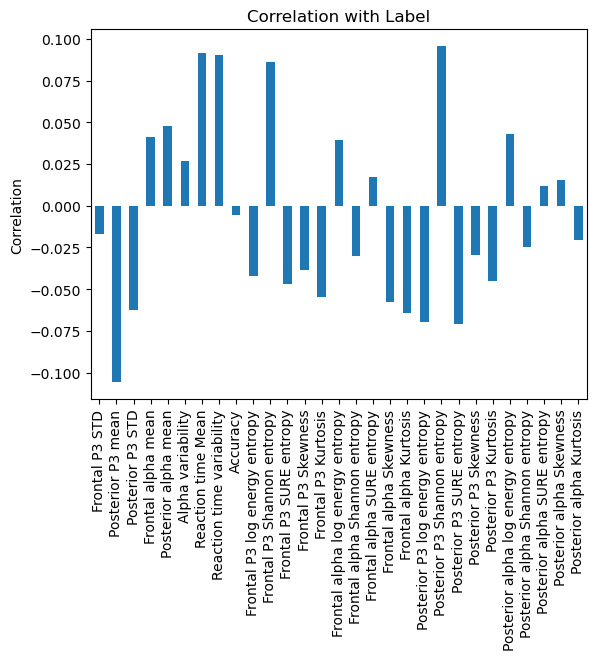

In [9]:
# All positive correlation coefficients:
# columns_to_drop = ['Posterior alpha Kurtosis', 'Posterior alpha Shannon entropy', 'Posterior P3 Kurtosis', 'Posterior P3 Skewness', 'Posterior']
corr = totalDF.iloc[:, 5:].corrwith(totalDF.Label)
corr.plot(kind='bar')
plt.title('Correlation with Label')
plt.ylabel('Correlation')
plt.show()

In [10]:
# Features with positive correlation with label
Label_Feature_PositiveCorr = totalDF[corr[corr>=0].index]

# Features with the top 5 correlation values with label
Label_Feature_Top5Corr = totalDF[corr.abs().nlargest(5).index]


### Variance Threshold

In [11]:
vt = VarianceThreshold(threshold=0.1)
vt.fit(all_features)
mask = vt.get_support()
print("Features excluded: ", all_features.columns[~mask].values)
vt_features = all_features.loc[:, mask]

Features excluded:  ['Accuracy' 'Frontal P3 Kurtosis' 'Frontal alpha Skewness'
 'Posterior P3 Skewness' 'Posterior P3 Kurtosis']


### SelectKBest - ANOVA

In [12]:
test = SelectKBest(score_func=f_classif, k=10)
fit = test.fit(all_features, Y)
mask = fit.get_support()
print("Features excluded: ", all_features.columns[~mask].values)
anova_features = all_features.loc[:, mask]

Features excluded:  ['Frontal P3 mean' 'Frontal P3 STD' 'Frontal alpha mean'
 'Posterior alpha mean' 'Alpha variability' 'Accuracy'
 'Frontal P3 log energy entropy' 'Frontal P3 SURE entropy'
 'Frontal P3 Skewness' 'Frontal P3 Kurtosis'
 'Frontal alpha log energy entropy' 'Frontal alpha Shannon entropy'
 'Frontal alpha SURE entropy' 'Posterior P3 Skewness'
 'Posterior P3 Kurtosis' 'Posterior alpha log energy entropy'
 'Posterior alpha Shannon entropy' 'Posterior alpha SURE entropy'
 'Posterior alpha Skewness' 'Posterior alpha Kurtosis']


### Sarah's Features

In [13]:
Sarahs5_features = all_features.iloc[:, [0,1,2,8,13]]
Sarahs10_features = all_features.iloc[:, [1,2,8,13,0,15,7,24,28,26]]

In [14]:
columns_from_LOSO = ['Frontal P3 STD', 'Posterior P3 mean', 'Frontal alpha mean']
Select3_from_LOSO = totalDF[columns_from_LOSO]

### Final Feature Selection

In [15]:
# 'AP' = alpha + posterior, 'APB' = alpha + posterior + behvaioural, 'all' = all features
Select_features = 'all'
Notes = ''

if Select_features == 'AP':
    X = alpha_posterior_features
elif Select_features == 'APB':
    X = alpha_posterior_behav_features
elif Select_features == 'Correlation Matrix':
    X = uncorr_features
elif Select_features == 'vt':
    X = vt_features
elif Select_features == 'ANOVA':
    X = anova_features
elif Select_features == 'kendalls':
    X = kendall_features
else: 
    X = all_features
    

scale = 3
if scale == 1:
    scaler = StandardScaler()
elif scale == 2:
    scaler = MinMaxScaler()
elif scale == 3:
    scaler = Normalizer()
else:
    scaler = None
    
# print(X.columns)
# Verify that Labels contain only 0 and 1:
# print(X.Label.unique())

# Feature Subset Analysis
We have recognized that RandomForest Classifier and CatBoost are the top models. Here we will use these models to evaluate the impact of each subset on the model.

In [87]:
# feature_subsets = {'all': all_features, 'Alpha + Posterior': alpha_posterior_features, 'Alpha + Posterior + Behavioural': alpha_posterior_behav_features, 
#                    'Frontal + Alpha + Posterior': frontal_alpha_posterior_features, 'Frontal': frontal_features}

feature_subsets = {'Correlation Matrix': uncorr_features, 
                   'Variance Threshold': vt_features, 
                   'ANOVA': anova_features, 
                   'Label-Feature Positive Correlation': Label_Feature_PositiveCorr, 
                   'Label-Feature Top 5 Correlation': Label_Feature_Top5Corr,
                   'Select 3 from LOSO': Select3_from_LOSO,
                   'all': all_features,
                   'Posterior': alpha_posterior_features,
                   'Posterior + Behavioural': alpha_posterior_behav_features,
                   'Frontal + Posterior': frontal_alpha_posterior_features,
                    'Frontal': frontal_features
                   }

feature_scoring = {'Balanced_Accuracy': [], 'MCC': [], 'AUC': [], 'tp': [], 'fp': [], 'fn': [], 'tn': []}
kf = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)


model = SVC(random_state=42, probability=True)
feature_results = {'Model': model.__class__.__name__, 'KSplits': kf.n_splits, 
                   'Feature_Subset': [], 'Bal_Acc': [], 'Matt_Corr_Coef': [], 'AUC': [], 'tp': [], 'fp': [], 'fn': [], 'tn': []}

for name, X in feature_subsets.items():
    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        
        # print(f"Feature subset: {name}")
        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        feature_scoring['Balanced_Accuracy'].append(metrics.balanced_accuracy_score(y_test, y_pred))
        feature_scoring['MCC'].append(metrics.matthews_corrcoef(y_test, y_pred))
        feature_scoring['AUC'].append(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
        feature_scoring['tp'].append(metrics.confusion_matrix(y_test, y_pred)[0,0])
        feature_scoring['fp'].append(metrics.confusion_matrix(y_test, y_pred)[0,1])
        feature_scoring['fn'].append(metrics.confusion_matrix(y_test, y_pred)[1,0])
        feature_scoring['tn'].append(metrics.confusion_matrix(y_test, y_pred)[1,1])
        
    # feature_results['Model'].append(model.__class__.__name__)
    feature_results['Feature_Subset'].append(name)
    feature_results['Bal_Acc'].append(np.mean(feature_scoring['Balanced_Accuracy']))
    feature_results['Matt_Corr_Coef'].append(np.mean(feature_scoring['MCC']))
    feature_results['AUC'].append(np.mean(feature_scoring['AUC']))
    feature_results['tp'].append(np.mean(feature_scoring['tp']))
    feature_results['fp'].append(np.mean(feature_scoring['fp']))
    feature_results['fn'].append(np.mean(feature_scoring['fn']))
    feature_results['tn'].append(np.mean(feature_scoring['tn']))


In [88]:
results_file = 'FeatureAnalysis.xlsx'
feature_results_df = pd.DataFrame(feature_results)
print(feature_results_df)
df_existingRecord = pd.read_excel(results_file)
df_combined = pd.concat([df_existingRecord, feature_results_df], ignore_index=True)
df_combined.drop_duplicates(subset=['Feature_Subset', 'Model',], keep='last', inplace = True)
# df_combined.sort_values(by='Matt_Corr_Coef', ascending=False, inplace=True)
df_combined.to_excel(results_file, index=False)

   Model  KSplits                      Feature_Subset   Bal_Acc  \
0    SVC       25                  Correlation Matrix  0.498643   
1    SVC       25                  Variance Threshold  0.498619   
2    SVC       25                               ANOVA  0.503571   
3    SVC       25  Label-Feature Positive Correlation  0.504006   
4    SVC       25     Label-Feature Top 5 Correlation  0.504243   
5    SVC       25                  Select 3 from LOSO  0.504405   
6    SVC       25                                 all  0.503575   
7    SVC       25                           Posterior  0.506833   
8    SVC       25             Posterior + Behavioural  0.508884   
9    SVC       25                 Frontal + Posterior  0.507950   
10   SVC       25                             Frontal  0.507212   

    Matt_Corr_Coef       AUC        tp        fp         fn         tn  
0        -0.002934  0.520519  3.160000  3.960000   9.120000  11.240000  
1        -0.002922  0.520579  3.160000  3.960000 

In [89]:
# results_file = 'FeatureAnalysis.xlsx'
# feature_results_df = pd.DataFrame(feature_results)
# print(feature_results_df)
# df_existingRecord = pd.read_excel(results_file)
# df_combined = pd.concat([df_existingRecord, feature_results_df], ignore_index=True)
# df_combined.drop_duplicates(subset=['Feature_Subset', 'Model',], keep='last', inplace = True)
# # df_combined.sort_values(by='Matt_Corr_Coef', ascending=False, inplace=True)
# df_combined.to_excel(results_file, index=False)

In [ ]:
# feature_subsets = {'all': all_features, 'Alpha + Posterior': alpha_posterior_features, 'Alpha + Posterior + Behavioural': alpha_posterior_behav_features, 
                #    'Frontal + Alpha + Posterior': frontal_alpha_posterior_features, 'Frontal': frontal_features}
feature_subsets = {'Correlation Matrix': uncorr_features, 
                   'Variance Threshold': vt_features, 
                   'ANOVA10': anova_features, 
                   'Label-Feature Positive Correlation': Label_Feature_PositiveCorr, 
                   'Label-Feature Top 5 Correlation': Label_Feature_Top5Corr}
feature_scoring = {'Balanced_Accuracy': [], 
                   'MCC': [], 
                   'AUC': [], 
                   'tp': [], 
                   'fp': [], 
                   'fn': [], 
                   'tn': []}
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


model = CatBoostClassifier(random_state=42, verbose=False)
feature_results = {'Model': model.__class__.__name__, 'KSplits': kf.n_splits, 'Feature_Subset': [], 'Bal_Acc': [], 'Matt_Corr_Coef': [], 'AUC': [], 'tp': [], 'fp': [], 'fn': [], 'tn': []}

for name, X in feature_subsets.items():
    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        feature_scoring['Balanced_Accuracy'].append(metrics.balanced_accuracy_score(y_test, y_pred))
        feature_scoring['MCC'].append(metrics.matthews_corrcoef(y_test, y_pred))
        feature_scoring['AUC'].append(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
        feature_scoring['tp'].append(metrics.confusion_matrix(y_test, y_pred)[0,0])
        feature_scoring['fp'].append(metrics.confusion_matrix(y_test, y_pred)[0,1])
        feature_scoring['fn'].append(metrics.confusion_matrix(y_test, y_pred)[1,0])
        feature_scoring['tn'].append(metrics.confusion_matrix(y_test, y_pred)[1,1])
        
    # feature_results['Model'].append(model.__class__.__name__)
    feature_results['Feature_Subset'].append(name)
    feature_results['Bal_Acc'].append(np.mean(feature_scoring['Balanced_Accuracy']))
    feature_results['Matt_Corr_Coef'].append(np.mean(feature_scoring['MCC']))
    feature_results['AUC'].append(np.mean(feature_scoring['AUC']))
    feature_results['tp'].append(np.mean(feature_scoring['tp']))
    feature_results['fp'].append(np.mean(feature_scoring['fp']))
    feature_results['fn'].append(np.mean(feature_scoring['fn']))
    feature_results['tn'].append(np.mean(feature_scoring['tn']))


In [ ]:
# results_file = 'FeatureAnalysis.xlsx'
# feature_results_df = pd.DataFrame(feature_results)
# print(feature_results_df)
# df_existingRecord = pd.read_excel(results_file)
# df_combined = pd.concat([df_existingRecord, feature_results_df], ignore_index=True)
# df_combined.drop_duplicates(subset=['Feature_Subset', 'Model',], keep='last', inplace = True)
# df_combined.sort_values(by='Matt_Corr_Coef', ascending=False, inplace=True)
# df_combined.to_excel(results_file, index=False)

                Model  KSplits                      Feature_Subset   Bal_Acc  \
0  CatBoostClassifier       10                  Correlation Matrix  0.528967   
1  CatBoostClassifier       10                  Variance Threshold  0.526915   
2  CatBoostClassifier       10                             ANOVA10  0.524176   
3  CatBoostClassifier       10  Label-Feature Positive Correlation  0.520075   
4  CatBoostClassifier       10     Label-Feature Top 5 Correlation  0.525720   

   Matt_Corr_Coef       AUC        tp         fp         fn         tn  
0        0.066861  0.543995  4.700000  13.100000  10.500000  40.400000  
1        0.058085  0.533375  4.750000  13.050000  10.850000  40.050000  
2        0.050778  0.540224  5.133333  12.666667  12.233333  38.666667  
3        0.041623  0.533790  5.175000  12.625000  12.775000  38.125000  
4        0.050757  0.538854  5.720000  12.080000  13.760000  37.140000  


# Model Selection

## Variables init
Choose what type of KFold, which measures you would like, what info you would like to store in results. Some resources:
- [svm](https://www.youtube.com/watch?v=efR1C6CvhmE)
- [Gradient Boosting info](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/)

@NOTE: MCC is around 0.5-0.6 so we would expect AUC to be around .7

In [16]:
rf_params = {
    'bootstrap': True, 
    'max_depth': 19, 
    'max_features': 'log2', 
    'max_samples': 0.7, 
    'min_samples_leaf': 2, 
    'min_samples_split': 2, 
    'n_estimators': 100
    
}

In [17]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
index = []
scores = {"Accuracy": [], "BA": [], "Matt_Corr_Coef": [], "tp": [], "tn": [], "fp": [], "fn": [], "AUC": []}
results = {'Timestamp': [], 'Features': [], 'Normalized': [], 'CrossVal': type(kf).__name__, 'Splits': kf.n_splits, 'model': [], "Accuracy": [], 
           "BA": [], "Matt_Corr_Coef": [], 'AUC': [], 'tp': [], 'tn': [], 'fp': [], 'fn': [], 'Notes': 'N.Trees = 250'}

# Fill this with the models you would like to test:
models = [
            # LogisticRegression(max_iter=1800, random_state=42),
            RandomForestClassifier(random_state=42, **rf_params)
          # GradientBoostingClassifier(random_state=42, verbose = False), 
          # SVC(random_state=42, probability = True),
        #   KNeighborsClassifier(), 
        #   XGBClassifier(random_state=42), 
        #   LGBMClassifier(random_state=42, verbose = 0), 
          # CatBoostClassifier(random_state=42, verbose = False)
          ]
# models = [CatBoostClassifier(depth= 6, iterations= 300, learning_rate= 0.1, random_state=42, verbose=False), 
#               RandomForestClassifier(bootstrap= False, max_depth= 29, max_features= "log2", min_samples_leaf= 1, 
#                                      min_samples_split= 2, n_estimators= 200, random_state=42),]
# models = [RandomForestClassifier(random_state=42)]
scaler = Normalizer()

In [96]:
# pipe = Pipeline([('smt', oversample),('normalizer', scaler), ('classifier', model)])
# cv_results = cross_validate(pipe, X, Y, cv=kf, scoring=scoring, return_train_score=True)

Complex nested loops. More information on the structure of this pipeline and SMOTE [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [22]:
model = RandomForestClassifier(random_state=42, **rf_params)
pipe = Pipeline([('smt', SMOTE(random_state=42)),('normalizer', scaler), ('classifier', model)])

cv = LeaveOneGroupOut()

print('RANDOM FOREST')
BA_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='balanced_accuracy', return_train_score=True)
print('Balanced Accuracy Test: %.3f (%.3f)' % (np.mean(BA_scores['test_score']), np.std(BA_scores['test_score'])))
print('Balanced Accuracy Train: %.3f (%.3f)' % (np.mean(BA_scores['train_score']), np.std(BA_scores['train_score'])))

MCC_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='matthews_corrcoef', return_train_score=True)
print('Matthew\'s Correlation Coefficient Test: %.3f (%.3f)' % (np.mean(MCC_scores['test_score']), np.std(MCC_scores['test_score'])))
print('Matthew\'s Correlation Coefficient Train: %.3f (%.3f)' % (np.mean(MCC_scores['train_score']), np.std(MCC_scores['train_score'])))

model = CatBoostClassifier(random_state=42, verbose=False)
pipe = Pipeline([('smt', SMOTE(random_state=42)),('normalizer', scaler), ('classifier', model)])
print('CATBOOST')
BA_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='balanced_accuracy', return_train_score=True)
print('Balanced Accuracy Test: %.3f (%.3f)' % (np.mean(BA_scores['test_score']), np.std(BA_scores['test_score'])))
print('Balanced Accuracy Train: %.3f (%.3f)' % (np.mean(BA_scores['train_score']), np.std(BA_scores['train_score'])))

MCC_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='matthews_corrcoef', return_train_score=True)
print('Matthew\'s Correlation Coefficient Test: %.3f (%.3f)' % (np.mean(MCC_scores['test_score']), np.std(MCC_scores['test_score'])))
print('Matthew\'s Correlation Coefficient Train: %.3f (%.3f)' % (np.mean(MCC_scores['train_score']), np.std(MCC_scores['train_score'])))

RANDOM FOREST
Balanced Accuracy Test: 0.524 (0.101)
Balanced Accuracy Train: 0.994 (0.003)
Matthew's Correlation Coefficient Test: 0.045 (0.170)
Matthew's Correlation Coefficient Train: 0.992 (0.004)
CATBOOST
Balanced Accuracy Test: 0.540 (0.117)
Balanced Accuracy Train: 0.998 (0.002)
Matthew's Correlation Coefficient Test: 0.053 (0.194)
Matthew's Correlation Coefficient Train: 0.997 (0.003)


In [23]:
X= Sarahs10_features
model = RandomForestClassifier(random_state=42, **rf_params)
pipe = Pipeline([('smt', SMOTE(random_state=42)),('normalizer', scaler), ('classifier', model)])

cv = LeaveOneGroupOut()

print('RANDOM FOREST')
BA_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='balanced_accuracy', return_train_score=True)
print('Balanced Accuracy Test: %.3f (%.3f)' % (np.mean(BA_scores['test_score']), np.std(BA_scores['test_score'])))
print('Balanced Accuracy Train: %.3f (%.3f)' % (np.mean(BA_scores['train_score']), np.std(BA_scores['train_score'])))

MCC_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='matthews_corrcoef', return_train_score=True)
print('Matthew\'s Correlation Coefficient Test: %.3f (%.3f)' % (np.mean(MCC_scores['test_score']), np.std(MCC_scores['test_score'])))
print('Matthew\'s Correlation Coefficient Train: %.3f (%.3f)' % (np.mean(MCC_scores['train_score']), np.std(MCC_scores['train_score'])))

model = CatBoostClassifier(random_state=42, verbose=False)
pipe = Pipeline([('smt', SMOTE(random_state=42)),('normalizer', scaler), ('classifier', model)])
print('CATBOOST')
BA_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='balanced_accuracy', return_train_score=True)
print('Balanced Accuracy Test: %.3f (%.3f)' % (np.mean(BA_scores['test_score']), np.std(BA_scores['test_score'])))
print('Balanced Accuracy Train: %.3f (%.3f)' % (np.mean(BA_scores['train_score']), np.std(BA_scores['train_score'])))

MCC_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='matthews_corrcoef', return_train_score=True)
print('Matthew\'s Correlation Coefficient Test: %.3f (%.3f)' % (np.mean(MCC_scores['test_score']), np.std(MCC_scores['test_score'])))
print('Matthew\'s Correlation Coefficient Train: %.3f (%.3f)' % (np.mean(MCC_scores['train_score']), np.std(MCC_scores['train_score'])))

RANDOM FOREST
Balanced Accuracy Test: 0.542 (0.115)
Balanced Accuracy Train: 0.984 (0.006)
Matthew's Correlation Coefficient Test: 0.069 (0.207)
Matthew's Correlation Coefficient Train: 0.967 (0.010)
CATBOOST
Balanced Accuracy Test: 0.543 (0.115)
Balanced Accuracy Train: 0.962 (0.006)
Matthew's Correlation Coefficient Test: 0.075 (0.168)
Matthew's Correlation Coefficient Train: 0.906 (0.013)


In [24]:
X= Sarahs5_features
model = RandomForestClassifier(random_state=42, **rf_params)
pipe = Pipeline([('smt', SMOTE(random_state=42)),('normalizer', scaler), ('classifier', model)])

cv = LeaveOneGroupOut()

print('RANDOM FOREST')
BA_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='balanced_accuracy', return_train_score=True)
print('Balanced Accuracy Test: %.3f (%.3f)' % (np.mean(BA_scores['test_score']), np.std(BA_scores['test_score'])))
print('Balanced Accuracy Train: %.3f (%.3f)' % (np.mean(BA_scores['train_score']), np.std(BA_scores['train_score'])))

MCC_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='matthews_corrcoef', return_train_score=True)
print('Matthew\'s Correlation Coefficient Test: %.3f (%.3f)' % (np.mean(MCC_scores['test_score']), np.std(MCC_scores['test_score'])))
print('Matthew\'s Correlation Coefficient Train: %.3f (%.3f)' % (np.mean(MCC_scores['train_score']), np.std(MCC_scores['train_score'])))

model = CatBoostClassifier(random_state=42, verbose=False)
pipe = Pipeline([('smt', SMOTE(random_state=42)),('normalizer', scaler), ('classifier', model)])
print('CATBOOST')
BA_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='balanced_accuracy', return_train_score=True)
print('Balanced Accuracy Test: %.3f (%.3f)' % (np.mean(BA_scores['test_score']), np.std(BA_scores['test_score'])))
print('Balanced Accuracy Train: %.3f (%.3f)' % (np.mean(BA_scores['train_score']), np.std(BA_scores['train_score'])))

MCC_scores = cross_validate(pipe, X, Y, cv=cv, groups=totalDF['Subject'], scoring='matthews_corrcoef', return_train_score=True)
print('Matthew\'s Correlation Coefficient Test: %.3f (%.3f)' % (np.mean(MCC_scores['test_score']), np.std(MCC_scores['test_score'])))
print('Matthew\'s Correlation Coefficient Train: %.3f (%.3f)' % (np.mean(MCC_scores['train_score']), np.std(MCC_scores['train_score'])))

RANDOM FOREST
Balanced Accuracy Test: 0.537 (0.100)
Balanced Accuracy Train: 0.952 (0.009)
Matthew's Correlation Coefficient Test: 0.054 (0.151)
Matthew's Correlation Coefficient Train: 0.895 (0.017)
CATBOOST
Balanced Accuracy Test: 0.525 (0.111)
Balanced Accuracy Train: 0.880 (0.011)
Matthew's Correlation Coefficient Test: 0.037 (0.155)
Matthew's Correlation Coefficient Train: 0.704 (0.021)


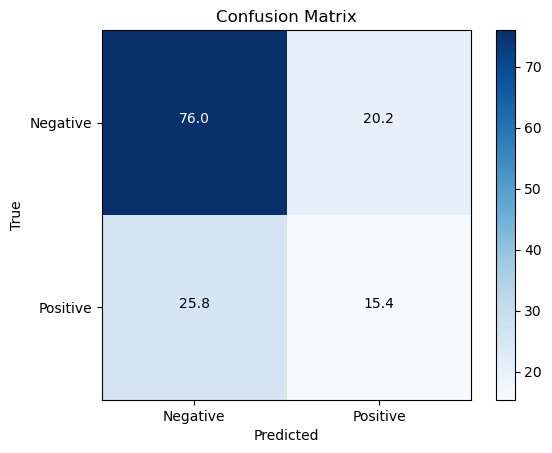

In [101]:
TP = 15.4
TN = 76
FP = 20.2
FN = 25.8

# Create the confusion matrix
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Define the labels for the matrix
labels = ['Negative', 'Positive']

# Plot the confusion matrix
plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the matrix
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Add text annotations
thresh = confusion_matrix.max() / 2
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, confusion_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

# Add axis labels
plt.xlabel('Predicted')
plt.ylabel('True')

# Show the plot
plt.show()

In [98]:
results_df = pd.DataFrame(results)

In [99]:
# print(cv_results.keys())
# train_scores = cv_results['train_balanced accuracy']
# test_scores = cv_results['test_balanced accuracy']
# print("Model: ", pipe.named_steps['classifier'])
# print("Train Scores: ", train_scores)
# print("Test Scores: ", test_scores)

## Record Results
Add these Results and Test Conditions to Results.xlsx. Will delete duplicate results within conditions.

### Save to file

In [100]:
results_file = 'TestBetweenSubject.xlsx'
print(results_df)
# df_existingRecord = pd.read_excel(results_file)
# df_combined = pd.concat([df_existingRecord, results_df], ignore_index=True)
# df_combined.drop_duplicates(subset=['Features', 'model', "Accuracy", "BA", "Matt_Corr_Coef", 'AUC', 'tp', 'fp', 'fn', 'tn', 'Notes'], keep='last', inplace = True)
# df_combined.sort_values(by='Matt_Corr_Coef', ascending=False, inplace=True)
# df_combined.to_excel(results_file, index=False)

                   Timestamp       Features  Normalized         CrossVal  \
0 2024-06-11 13:48:32.505778  Select10Sarah  Normalizer  StratifiedKFold   

   Splits                   model  Accuracy        BA  Matt_Corr_Coef  \
0       5  RandomForestClassifier   0.66526  0.589446        0.171279   

       AUC    tp    tn    fp    fn          Notes  
0  0.59655  15.4  76.0  20.2  25.8  N.Trees = 250  


# Plot ROC curve

In [ ]:
def scatter_plot(X_train, y_train):
    colors_palette = {0: 'green', 1: 'red'}
    colors = [colors_palette[c] for c in y_train]
    grr = pd.plotting.scatter_matrix(X_train, c=colors, marker=".", figsize =(20,15), alpha = 0.8, range_padding=0.05, diagonal="kde" , s=60, grid=True)
    # plt.savefig("scatter_kaggle_normalized(5 attr).png")
    plt.show()
scatter_plot(X, Y)

In [41]:
# Assuming clf is your classifier and X, y are your data and labels
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
X = alpha_posterior_behav_features
clf = SVC(random_state=42, probability=True)
# X = vt_features
# clf = RandomForestClassifier(random_state=42)
# clf = LogisticRegression(max_iter=1800, random_state=42)
# clf = LGBMClassifier(random_state=42)
# clf = XGBClassifier(random_state=42)
clf = CatBoostClassifier(random_state=42, verbose=False)

i = 0
for train, test in cv.split(X, Y):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X.iloc[train], Y.iloc[train])
    # under = RandomUnderSampler(random_state=42)
    # X_res, y_res = under.fit_resample(X_res, y_res)
    normalized = Normalizer()
    X_res = normalized.fit_transform(X_res)
    X_test_normalized = normalized.transform(X.iloc[test])
    probas_ = clf.fit(X_res, y_res).predict_proba(X_test_normalized)
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = metrics.roc_curve(Y[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost ROC Curve')
plt.legend(loc="lower right")
plt.show()

NameError: name 'alpha_posterior_behav_features' is not defined

# Tuning Hyperparameters

In [ ]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()

## SVC 

In [34]:
X = alpha_posterior_features
param_grid = {
    'classifier__C': [0.1, 1, 10, 100, 1000],
    'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'classifier__kernel': ['rbf', 'poly'],
}
pipe = Pipeline([('smt', SMOTE(random_state=42)), ('normalizer', Normalizer()), ('svc', SVC(random_state=42))])
StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)


In [ ]:

# for train_index, test_index in kf.split(X, Y):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
#     grid.fit(X_train, y_train)
#     # plot_search_results(grid)
#     print(grid.best_params_)
#     print(grid.best_score_)
#     print(grid.score(X_test, y_test))
    

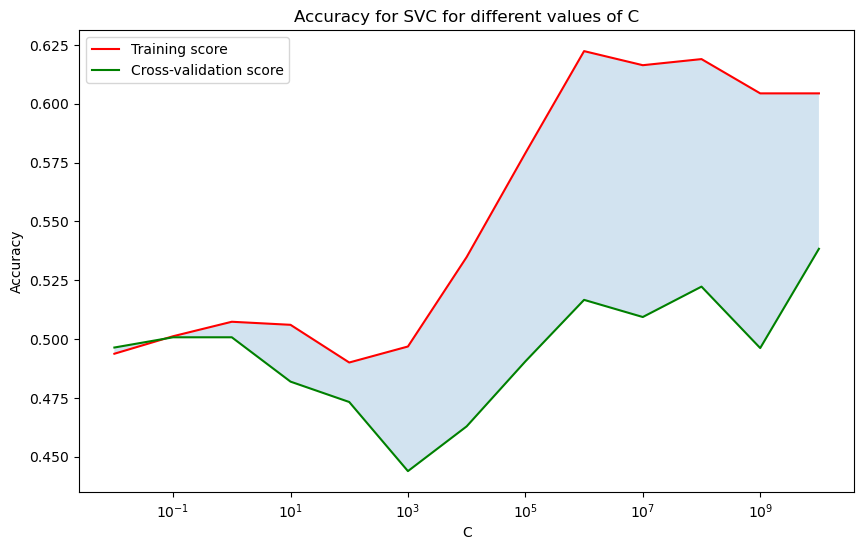

In [14]:
C_range = np.logspace(-2, 10, 13)

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(svc__C=C_range)

# Instantiate the grid
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy', return_train_score=True)

# Fit the grid with data
grid.fit(X, Y)

# Plot the scores of the grid
# GridSearchCV.cv_results_ contains the mean score for each parameter combination
train_scores_mean = grid.cv_results_['mean_train_score']
test_scores_mean = grid.cv_results_['mean_test_score']

plt.figure().set_size_inches(10, 6)
plt.semilogx(C_range, train_scores_mean, label='Training score', color='r')
plt.semilogx(C_range, test_scores_mean, label='Cross-validation score', color='g')

plt.fill_between(C_range, train_scores_mean, test_scores_mean, alpha=0.2)
plt.legend(loc='best')
plt.title('Accuracy for SVC for different values of C')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

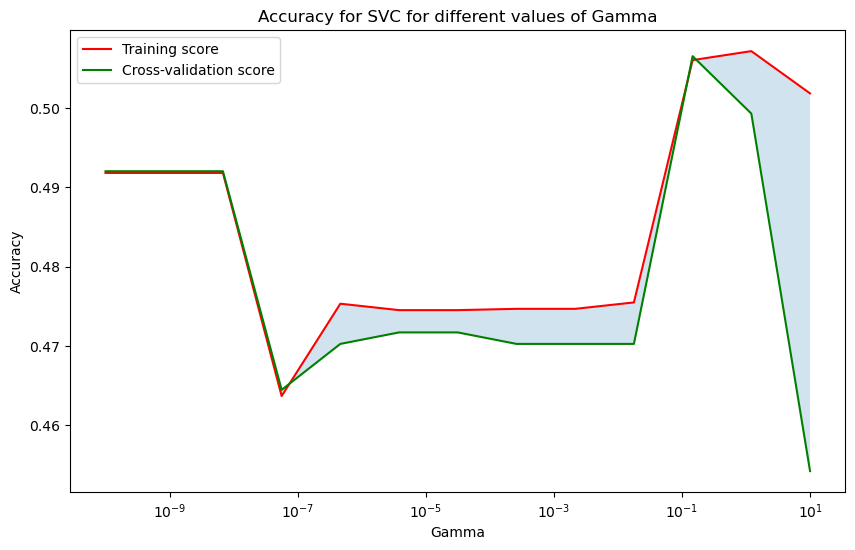

In [35]:
G_range = np.logspace(-10, 1, 13)

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(svc__gamma=G_range)

# Instantiate the grid
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy', return_train_score=True)

# Fit the grid with data
grid.fit(X, Y)

# Plot the scores of the grid
# GridSearchCV.cv_results_ contains the mean score for each parameter combination
train_scores_mean = grid.cv_results_['mean_train_score']
test_scores_mean = grid.cv_results_['mean_test_score']

plt.figure().set_size_inches(10, 6)
plt.semilogx(G_range, train_scores_mean, label='Training score', color='r')
plt.semilogx(G_range, test_scores_mean, label='Cross-validation score', color='g')

plt.fill_between(G_range, train_scores_mean, test_scores_mean, alpha=0.2)
plt.legend(loc='best')
plt.title('Accuracy for SVC for different values of Gamma')
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.show()

In [44]:
print(Sarahs5_features.columns)

Index(['Frontal P3 mean', 'Frontal P3 STD', 'Posterior P3 mean',
       'Reaction time variability', 'Frontal P3 Skewness'],
      dtype='object')


## Random Forest Classifier

Fitting 5 folds for each of 14 candidates, totalling 70 fits


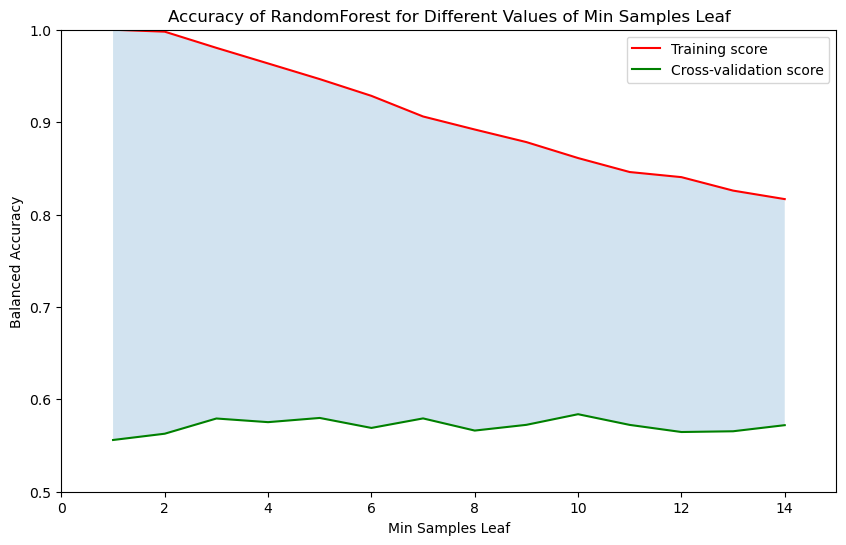

In [51]:
param_grid = {
    # 'classifier__n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500],
    # 'classifier__max_depth': [3, 7, 9, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49],
    # 'classifier__min_samples_split': list(range(2, 150, 3)),
    # 'classifier__min_samples_leaf': list(range(1, 15, 1)),
    # 'classifier__max_features': ['log2', 'auto'],
#     'classifier__bootstrap': [False, True]
}
pipe = Pipeline([('smt', SMOTE(random_state=42)), ('normalizer', Normalizer()), ('classifier', RandomForestClassifier(random_state=42))])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = GridSearchCV(estimator=pipe, 
                                param_grid=param_grid, cv=kf, verbose=2,
                                n_jobs=-1, scoring='balanced_accuracy', return_train_score=True)
cv.fit(Sarahs10_features, Y)
# Plot the scores of the grid
# GridSearchCV.cv_results_ contains the mean score for each parameter combination
train_scores_mean = cv.cv_results_['mean_train_score']
test_scores_mean = cv.cv_results_['mean_test_score']

# Assuming 'classifier__max_depth' is a parameter in cv.cv_results_
max_depths = param_grid['classifier__min_samples_leaf']

plt.figure().set_size_inches(10, 6)
plt.plot(max_depths, train_scores_mean, label='Training score', color='r')
plt.plot(max_depths, test_scores_mean, label='Cross-validation score', color='g')

plt.fill_between(max_depths, train_scores_mean, test_scores_mean, alpha=0.2)
plt.legend(loc='best')
plt.title('Accuracy of RandomForest for Different Values of Min Samples Leaf')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Balanced Accuracy')
plt.axis([0, 15, .5, 1])
plt.show()

In [41]:
print(list(range(2, 150, 3)))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [20]:
cv.fit(Sarahs5_features, Y.values.ravel())
results = pd.DataFrame({"classifier__max_depth": [param["classifier__max_depth"] for param in cv.cv_results_['params']],
           "mean_score": list(cv.cv_results_['mean_test_score']),
           "std_score": cv.cv_results_['std_test_score']})
results = results.dropna()
results

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,classifier__max_depth,mean_score,std_score
0,15,0.514396,0.034399
1,17,0.508865,0.029043
2,19,0.500298,0.022476
3,21,0.510018,0.019662
4,23,0.502259,0.018875
5,25,0.500298,0.015027


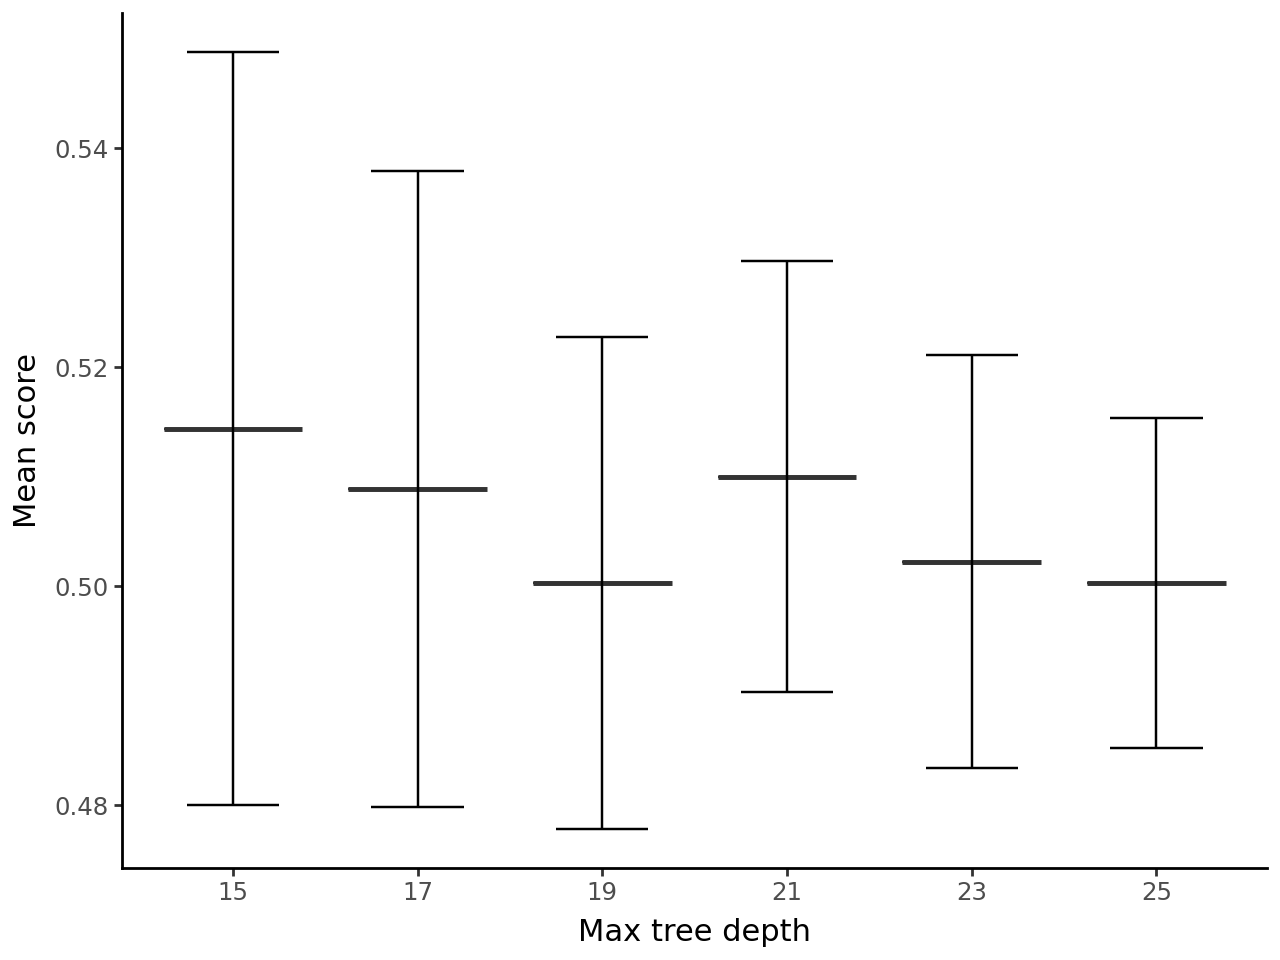

In [18]:
# (
#    ggplot(results) + geom_boxplot(aes(x='factor(classifier__max_depth)', y='mean_score')) 
#    + geom_errorbar(aes(x='factor(classifier__max_depth)', ymin='mean_score - std_score', ymax='mean_score + std_score')) 
#    +  theme_classic() + xlab('Max tree depth') + ylab('Mean score')
# )

## Random Forest Classifier - Alt Grid Search

### Part 1

In [77]:
# Number of trees in random forest
n_estimators = [20,60,100,120,200,250,300]

# Number of features to consider at every split
# max_features = [0.2,0.6,1.0]

# Maximum number of levels in tree
max_depth = [2,8,None]

# Number of samples
max_samples = [0.5,0.75,1.0]

# total 108 diff random forest train

In [78]:
param_grid = {'classifier__n_estimators': n_estimators,
              #  'classifier__max_features': max_features,
            #    'classifier__max_depth': max_depth,
              'classifier__max_samples':max_samples
             }
print(param_grid)

{'classifier__n_estimators': [20, 60, 100, 120, 200, 250, 300], 'classifier__max_features': [0.2, 0.6, 1.0], 'classifier__max_samples': [0.5, 0.75, 1.0]}


In [79]:
pipe = Pipeline([('smt', SMOTE(random_state=42)), ('normalizer', Normalizer()), ('classifier', RandomForestClassifier(random_state=42))])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=kf, verbose=2, n_jobs=-1, scoring='matthews_corrcoef', return_train_score=True)
cv.fit(Sarahs10_features, Y)
base_params = cv.best_params_

Fitting 5 folds for each of 63 candidates, totalling 315 fits


In [80]:
cv.best_score_

0.1859679072079024

In [81]:
cv.best_params_

{'classifier__max_features': 1.0,
 'classifier__max_samples': 0.75,
 'classifier__n_estimators': 250}

### Part 2

In [89]:
param_grid = {
    'classifier__n_estimators': [100, 150, 200, 250, 300],
    'classifier__max_depth': [17, 19, 21],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [2],
    'classifier__max_features': ['log2'],
    'classifier__bootstrap': [True],
    'classifier__max_samples': [0.5,.7, 0.75,.8, 1.0]
}
model = RandomForestClassifier(random_state=42)
pipe = Pipeline([('smt', SMOTE(random_state=42)), ('normalizer', Normalizer()), ('classifier', model)])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv2 = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=kf, verbose=2, n_jobs=-1, scoring='matthews_corrcoef', return_train_score=True)
cv2.fit(Sarahs10_features, Y)
print(cv2.best_params_)
print(cv2.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'classifier__bootstrap': True, 'classifier__max_depth': 19, 'classifier__max_features': 'log2', 'classifier__max_samples': 0.7, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
0.17127880866784925


In [87]:
cv2.best_params_

{'classifier__bootstrap': True,
 'classifier__max_depth': 17,
 'classifier__max_features': 'log2',
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 150}

In [85]:
cv2.best_score_

0.15247373299052117

## Random Search Training

## CatBoost
[Hyperparameter tutorial](https://www.geeksforgeeks.org/catboost-parameters-and-hyperparameters/)

In [21]:
X = uncorr_features
catboost_pool = Pool(X, label = Y)
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'MultiClass',
    'verbose': 200,
    'random_state': 42
}
cv_results, cv_model = cv(catboost_pool, params, fold_count=5, plot=True, verbose=200, return_models=True, stratified=True)
available_metrics = [metric for metric in cv_results.columns if 'test' in metric]
print(available_metrics)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.6711841	test: 0.6768894	best: 0.6768894 (0)	total: 126ms	remaining: 2m 6s
200:	learn: 0.1565821	test: 0.5862259	best: 0.5624659 (46)	total: 1.38s	remaining: 5.48s
400:	learn: 0.0662619	test: 0.6314215	best: 0.5624659 (46)	total: 2.4s	remaining: 3.58s
600:	learn: 0.0365652	test: 0.6773662	best: 0.5624659 (46)	total: 3.04s	remaining: 2.02s
800:	learn: 0.0240501	test: 0.7168340	best: 0.5624659 (46)	total: 3.7s	remaining: 919ms
999:	learn: 0.0175629	test: 0.7446482	best: 0.5624659 (46)	total: 4.44s	remaining: 0us

bestTest = 0.5624658572
bestIteration = 46

Training on fold [1/5]
0:	learn: 0.6731328	test: 0.6774387	best: 0.6774387 (0)	total: 3.92ms	remaining: 3.91s
200:	learn: 0.1569696	test: 0.5961190	best: 0.5679273 (57)	total: 1.01s	remaining: 4.02s
400:	learn: 0.0664939	test: 0.6339287	best: 0.5679273 (57)	total: 1.81s	remaining: 2.7s
600:	learn: 0.0376481	test: 0.6703753	best: 0.5679273 (57)	total: 2.47s	remaining: 1.64s
800:	learn: 0.0246776	test: 0

In [ ]:
# Define the parameter grid
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [4, 6, 8]
}

# Create the CatBoostClassifier
model = CatBoostClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create a new CatBoostClassifier with the best parameters
# best_model = CatBoostClassifier(**best_params)

In [26]:
print(best_params)
print(best_score)

{'depth': 6, 'iterations': 300, 'learning_rate': 0.1}
0.8281781672143118
